# Godwin's Law on Reddit

Author: [@edridgedsouza](https://github.com/edridgedsouza/GODWIN)

Second Jupyter notebook for playing with the database while the other one is busy scraping.

**DISCLAIMER**: The selection of subreddits is clearly not random. By necessity, it includes
the most popular subreddits and subreddits that include the most-commented threads, as well
as some individually added political (or political-adjacent) subs. This alone tells you that
the sample space is not truly random; however, this is partly necessary as the only way to 
sample threads with high comment counts is often to take the most popular subs. However,
the manual inclusion of so many political subs likely influences the results and averages,
so another analysis is needed to see the rates only for explicitly non-political subs.


To account for the bias provided by adding in political subs, part of this analysis
will also attempt to calculate separate statistics for subs that aren't political or
political-adjacent. However, this is clearly very subjective as even nominally 
"apolitical" content can very much be political. Anyone who wishes to categorize the subs
differently can download the database and try their own custom visualization.

Terminology: a "failure event" in a thread is any reference to any of the "failure words" in
[Scraper.py](https://github.com/edridgedsouza/GODWIN/blob/master/godwin/Scraper.py#L42).

In [1]:
from godwin import Database, Scraper
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, NelsonAalenFitter
import warnings
warnings.filterwarnings('ignore')

db = Database('Godwin.db')
posts = db.get_data()

qry = '''
        SELECT 
            subreddit, 
            count(comment_id) AS n_failing,
            count(post_id) AS n_total,
            round(100.0*count(comment_id)/count(post_id), 2)
                AS percent_failing,
            round(avg(num_comments), 2) 
                AS avg_comments,
            round(avg(num_prev_comments), 2) 
                AS avg_failure_comments
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing DESC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
summary['percent_failing'] = summary['percent_failing'].astype(str) + '%'

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'{summary.shape[0]} subs, {posts.shape[0]} total posts')
    display(summary)

225 subs, 40349 total posts


,subreddit,n_failing,n_total,percent_failing,avg_comments,avg_failure_comments
0,politics,172,211,81.52%,18538.87,582.19
1,ENLIGHTENEDCENTRISM,150,192,78.13%,795.36,23.27
2,PoliticalHumor,151,197,76.65%,2575.27,146.72
3,PoliticalCompassMemes,153,204,75.0%,1711.26,138.55
4,RussiaLago,84,113,74.34%,332.60,93.74
5,PublicFreakout,145,205,70.73%,6193.19,361.73
6,Libertarian,138,196,70.41%,1778.44,186.33
7,AskTrumpSupporters,103,147,70.07%,1361.68,412.13
8,Conservative,139,199,69.85%,2598.01,399.02
9,AskReddit,141,202,69.8%,27963.53,1972.82


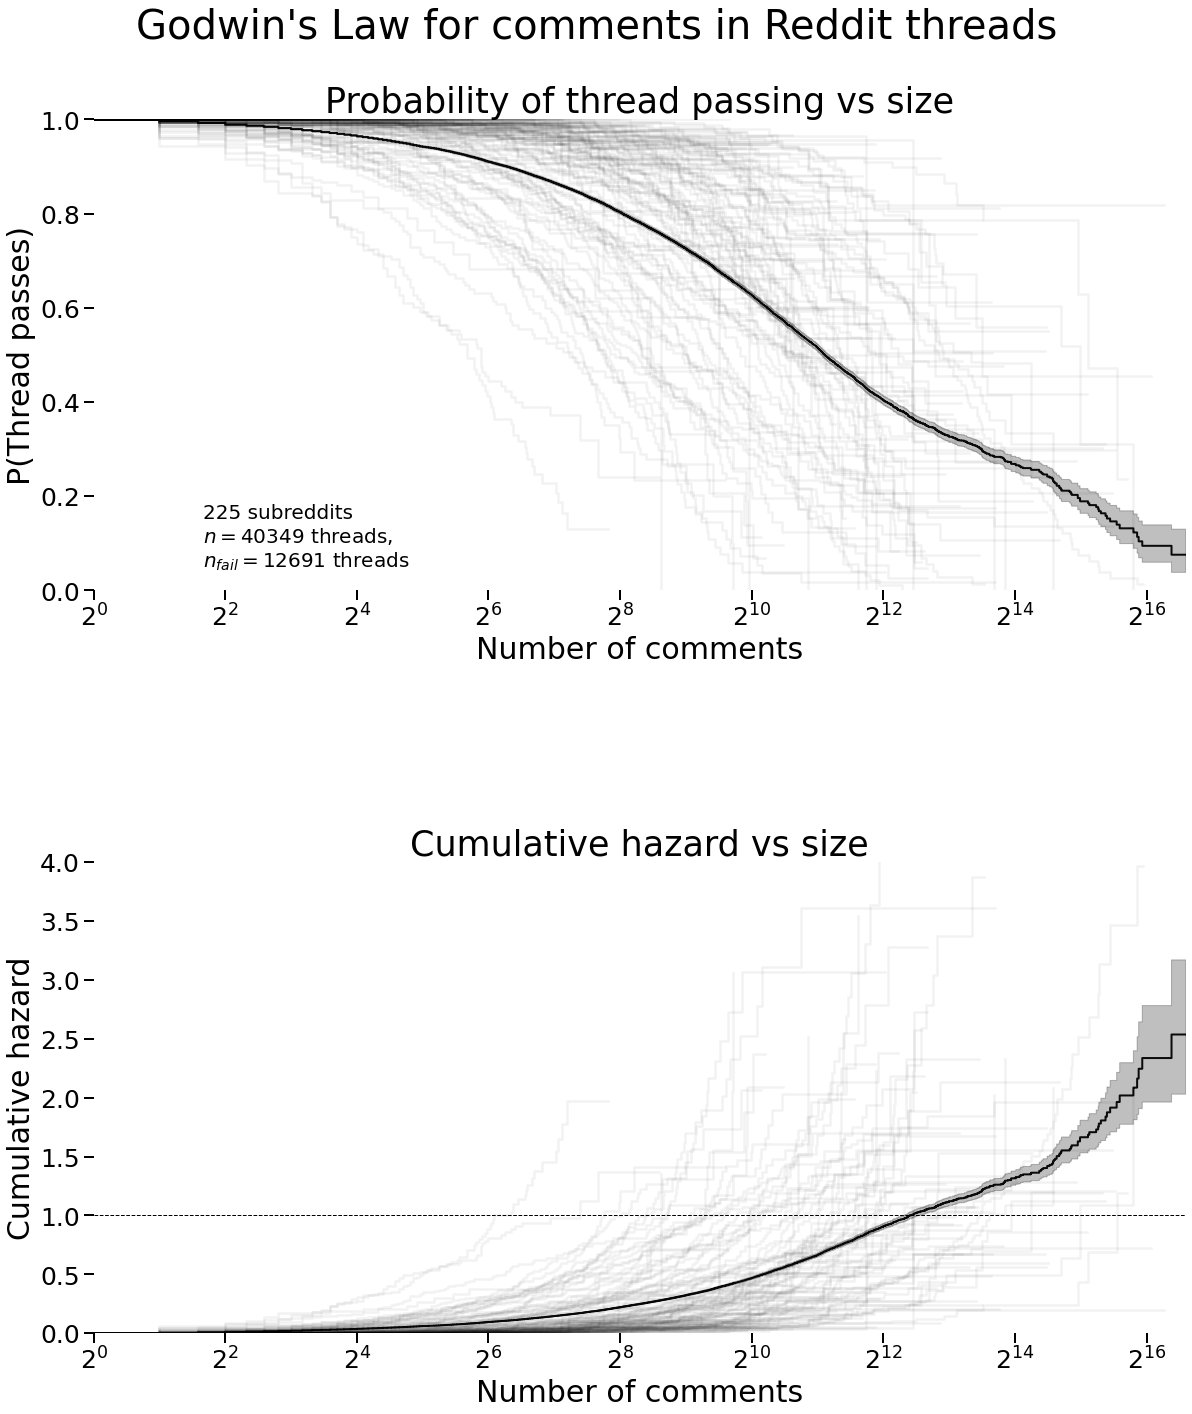

In [2]:
posts = db.get_data(fillna=True)

(fig, ax) = plt.subplots(2,1, figsize=(25 * 2/3, 15 * 4/3), facecolor=(1,1,1))

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

# TODO: Replace with for subreddit, subset in posts.groupby('subreddit'):
# TODO: highlight the subset of political subs
for sub in subs:
    subset = posts[posts.subreddit == sub]
    if subset.shape[0] != 0:
        kmf = KaplanMeierFitter()
        kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        kmf.plot(alpha=0.05, color='black', lw=2.5,
                 ci_show=False, ax=ax[0])
        
        naf = NelsonAalenFitter()
        naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        naf.plot(alpha=0.05, color='black', lw=2.5,
                 ci_show=False, ax=ax[1])
    
# Average model of all data
kmf = KaplanMeierFitter()
kmf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
kmf.plot(color='black', alpha=0.95, lw=2, ax=ax[0])

naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot(alpha=0.95, color='black', lw=2,
         ci_show=True, ax=ax[1])
####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads\n", fontsize=40)
ax[0].set_title('Probability of thread passing vs size', fontsize=35)
ax[0].set_ylabel('P(Thread passes)', fontsize=30)
ax[1].set_title('Cumulative hazard vs size', fontsize=35)
ax[1].set_ylabel('Cumulative hazard', fontsize=30)

ax[1].set_ylim(0, 4)  # TODO: evaluate this
ax[1].axhline(y=1.0, xmin=0, 
              xmax=posts.num_prev_comments.max(), 
              ls='--', lw=1, color='black')

for i in [0,1]:
    ax[i].set_xscale('log', base=2)
    ax[i].margins(x=0., y=0.)

    ax[i].get_legend().remove()
    ax[i].set_frame_on(False)

    ax[i].set_xlabel('Number of comments', fontsize=30)
    ax[i].tick_params(axis='x', labelsize=25)
    ax[i].tick_params(axis='y', labelsize=25)
    ax[i].tick_params(direction='out', length=10, width=2, colors='black')



samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.1, 0.05, samplesize, transform=ax[0].transAxes, fontsize=20)

fig.tight_layout()


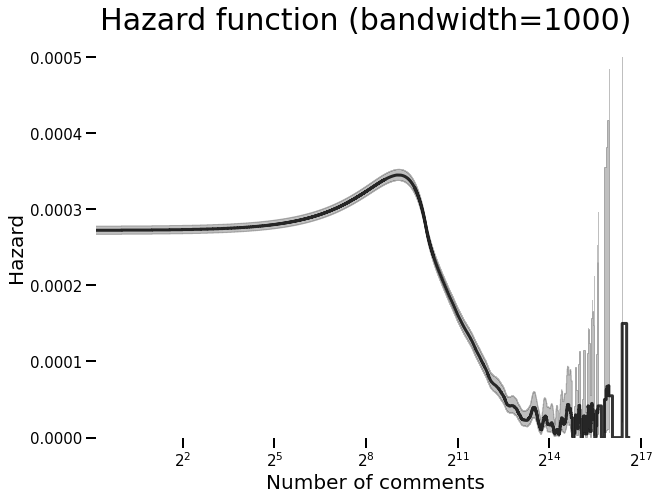

In [3]:
posts = db.get_data(fillna=True)

(fig, ax) = plt.subplots(1,1, figsize=(10,7), facecolor=(1,1,1))
naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot_hazard(color='black', alpha=0.8, ax=ax, lw=3, bandwidth=1000)
ax.set_xscale('log', base=2)

fig.suptitle('Hazard function (bandwidth=1000)', fontsize=30)
ax.set_xlabel('Number of comments', fontsize=20)
ax.set_ylabel('Hazard', fontsize=20)
ax.set_ylim(0, 0.0005)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.get_legend().remove()
plt.box(on=None)

# Good amount of noise for higher n_comments

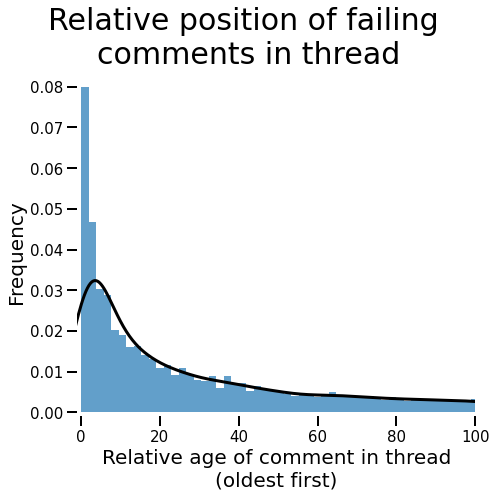

In [4]:
posts = db.get_data(fillna=True)

hits = posts[posts.failure == 1]

# Can technically be somewhat over 100 since the two different APIs 
# don't seem to be in exact accordance with each other
hits['percentile'] = (5*100*hits.num_prev_comments/hits.num_comments).round()/5

(fig, ax) = plt.subplots(1,1, figsize=(7,7), facecolor=(1,1,1))
hits['percentile'].plot.hist(density=True, bins=100, alpha=0.7, ax=ax)
hits['percentile'].plot.kde(legend=False, color='black', lw=3, ax=ax)

ax.set_xlabel('Relative age of comment in thread\n(oldest first)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
fig.suptitle('Relative position of failing \ncomments in thread', fontsize=30)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.set_xlim(-1, 100)
ax.set_ylim(-0.001, 0.08)
fig.tight_layout()
plt.box(on=None)

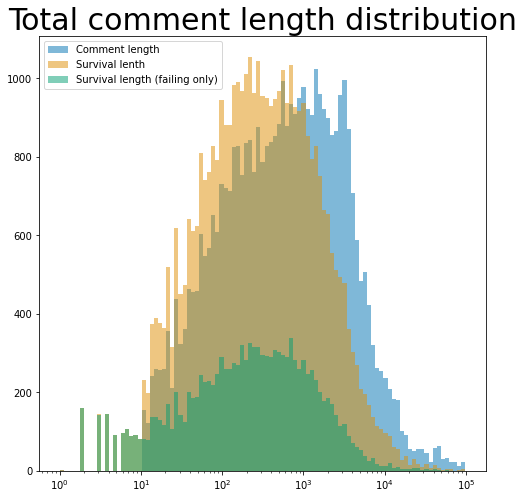

In [5]:
posts = db.get_data(fillna=True)

x = np.geomspace(1, posts.num_prev_comments.max(), num=100)
(fig, ax) = plt.subplots(1, 1, figsize=(8,8), facecolor=(1,1,1))
cm = sns.color_palette("colorblind")

ax.set_title('Total comment length distribution', fontsize=30)
params = {'stacked':False, 'fill':True, 'alpha': 0.5, 'edgecolor': 'none', 'bins': x}
d1 = ax.hist(posts.num_comments,  **params, 
             label='Comment length', color=cm[0])
d2 = ax.hist(posts.num_prev_comments, **params, 
             label='Survival lenth', color=cm[1])
d3 = ax.hist(posts[posts.failure == 1].num_prev_comments, **params, 
             label='Survival length (failing only)', color=cm[2])

ax.legend(facecolor='white')
ax.set_xscale("log")

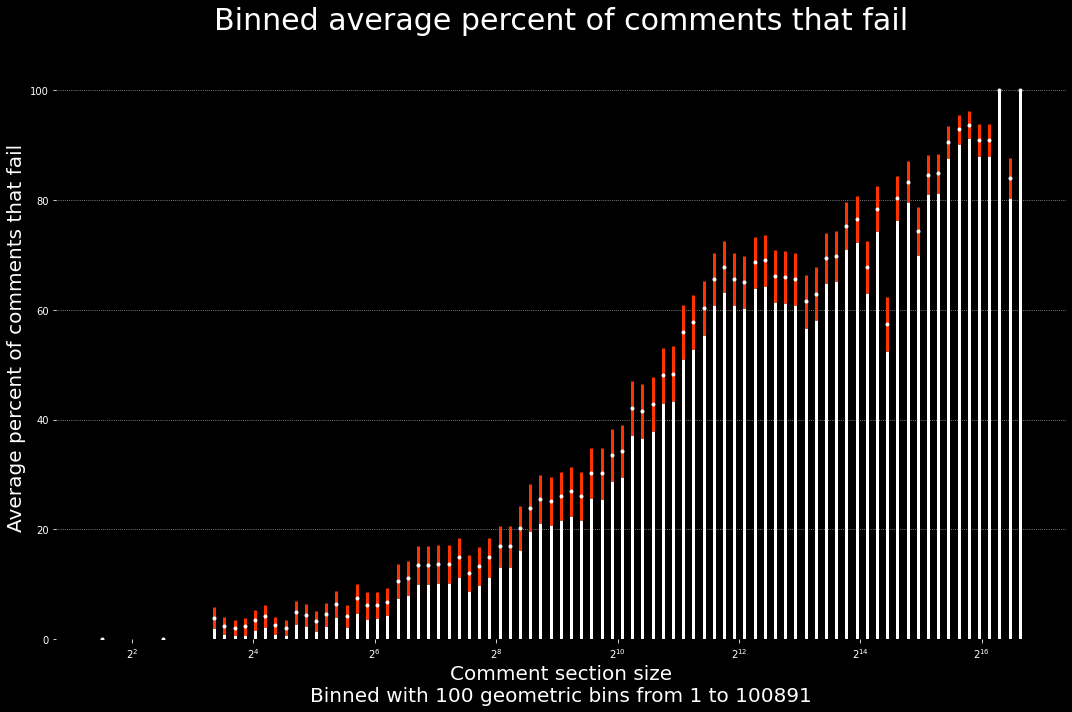

In [6]:
posts = db.get_data(fillna=True)

maximum = posts.num_comments.max()
x = np.geomspace(1, maximum, num=100)

# There is definitely a smarter way to group results into uneven width bins
grps = [0] * len(x)
for i in range(len(x)):  # doesn't let you just iterate over x?
    bin_min = x[i]
    if i < len(x) - 1:
        bin_max = x[i+1]
    else:
        bin_max = np.Inf
        
    subset = posts[(posts.num_comments > bin_min) & (posts.num_comments < bin_max)]
    grps[i] = list(subset.failure)

p = np.array([np.mean(i) for i in grps])
sd = np.sqrt(p * (1-p)/len(p)) * 100
p = p * 100

(fig, ax) = plt.subplots(1,1, figsize=(15, 10), facecolor=(0,0,0))
data = pd.DataFrame({'x':x, 'p': p, 'sd': sd})
data = data[~pd.isnull(data.p)]

ax.vlines(x=data.x, ymin=0, ymax=data.p-data.sd, color=(1,1,1), lw=3)
ax.vlines(x=data.x, ymin=data.p-data.sd, ymax=data.p+data.sd, color=(1,0.2,0), lw=3)
ax.plot(data.x, data.p, "o", c='white', markersize=3)

ax.set_ylim(0, 110)
ax.set_xscale('log', base=2)

ax.set_title('Binned average percent of comments that fail', fontsize=30, color='white')
ax.set_xlabel(f'Comment section size\nBinned with 100 geometric bins from 1 to {maximum}', fontsize=20, color='white')
ax.set_ylabel(f'Average percent of comments that fail', fontsize=20, color='white')

fig.tight_layout()
ax.grid(which='major', axis='y', linestyle=':')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.box(on=None)

# Note: these represent only the average of the comments size WITHIN each of the bin boundaries
# NOT the same as the cumulative probability in the survival plot

Text(0.5, 1.0, 'Failure frequency vs comments section size')

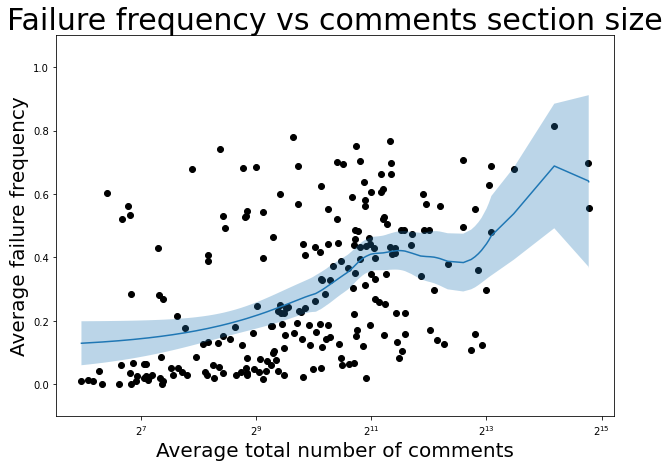

In [7]:
from skmisc.loess import loess

posts = db.get_data(fillna=False)

data = posts.groupby(['subreddit']).mean().sort_values('num_comments')
x, y = data.num_comments, data.failure
l = loess(x,y, surface='direct')
prd = l.predict(x, stderror=True)
ci = prd.confidence()


(fig, ax) = plt.subplots(1,1, figsize=(10,7), facecolor=(1,1,1))

ax.scatter(x,y, c='black')
ax.plot(x, prd.values)
ax.fill_between(x, ci.lower, ci.upper, alpha=0.3)

ax.set_xlabel('Average total number of comments', fontsize=20)
ax.set_ylabel('Average failure frequency', fontsize=20)
ax.set_xscale('log', base=2)
ax.set_ylim(-.1, 1.1)
ax.set_title('Failure frequency vs comments section size', fontsize=30)

In [ ]:
# Based on https://seaborn.pydata.org/examples/kde_ridgeplot.html

import matplotlib.patheffects as PathEffects

posts = db.get_data(fillna=False)


subset = posts[(posts.failure == 1)]
fail_ct = subset.groupby('subreddit')['failure'].count()
fail_ct = fail_ct[fail_ct > 3]  # > 3 normally, > 130 for testing
subset = subset[subset.subreddit.isin(fail_ct.index)]
order = subset.groupby('subreddit')["num_prev_comments"].median().sort_values().index


sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(len(order), start=2.1, rot=0., gamma=0.9, hue=1, 
                            dark=0.1, light=0.6, reverse=True)
g = sns.FacetGrid(subset, row="subreddit", hue="subreddit", 
                  aspect=15, height=1, palette=pal, sharey=False,
                 row_order = order, hue_order=order).set(xscale ='log')

# Draw the densities in a few steps
g.map(sns.kdeplot, "num_prev_comments",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "num_prev_comments", 
      clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Draw the mean and stdev https://stackoverflow.com/a/63309583/15014819
def draw_interval(x, color, label):
    ax = plt.gca()
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    
    middle = x.median()
    left, middle, right = np.percentile(x, [25, 50, 75])
    
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='white', ls=':')
    ax.fill_between(xs, -0.1, ys, where=(left <= xs) & (xs <= right), 
                    interpolate=False, facecolor='white', alpha=0.2)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    txt = ax.text(0, .2, f'/r/{label}', fontweight="bold", color=color,
            ha="left", va="bottom", transform=ax.transAxes, fontsize=16)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

g.map(label, "num_prev_comments")
g.map(draw_interval, "num_prev_comments")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.333)
g.despine(bottom=True, left=True)

g.set_titles("")
g.axes[0,0].set_title('For failing threads, how long does it take \nto demonstrate Godwin\'s Law?', fontsize=35)
g.axes[-1,0].set_xlabel('Number of comments before failure', fontsize=25)
g.axes[-1,0].tick_params(axis='x', labelsize=20)
g.set(yticks=[])

# KDE plotted, each row has a different y axis. Median dotted line, 25th-75th %ile shaded

KeyboardInterrupt: 

In [ ]:
posts = db.get_data(fillna=False)


qry = '''
        SELECT 
            subreddit, 
            count(post_id) as n,
            1.0*count(comment_id)/count(post_id) AS p,
            round(100.0*count(comment_id)/count(post_id), 2)
                AS percent_failing
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing ASC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
summary.stdev = np.sqrt(summary.p * (1-summary.p) / summary.n) * 100

y = summary.subreddit
y_n = np.arange(1,  len(y)+1)
x = summary.percent_failing

(fig, ax) = plt.subplots(1,1, figsize=(10, 50), facecolor=(1,1,1))

ax.hlines(y=y, xmin=0, xmax=x-summary.stdev, color=(0,0,0,0.1), lw=4)
ax.hlines(y=y, xmin=x-summary.stdev, xmax=x+summary.stdev, color=(1,0,0), lw=4)
ax.plot(x, y, "o", c='black', markersize=8)

# These are really reversed
ax.set_xlim(0, 101)
ax.set_ylim(-1, len(y)+1)


ax.set_title('Which subs fail the most?', fontsize=36)
ax.set_xlabel('Percentage of threads that fail', fontsize=30)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=25)

avg = posts.count().comment_id / posts.count().post_id * 100
ax.axvline(x=avg, ymin=0, ymax=len(y), ls=':', lw=2, color='#999999', zorder=-1)
ax.text(avg+2, round(len(y)/2)+10, 
        f'Average: {round(avg, 2)}%', 
        fontsize=20, color='#999999')

fig.tight_layout()
ax.grid(which='major', axis='x', linestyle=':')
plt.box(on=None)